<a href="https://colab.research.google.com/github/f-lingo/Obsidian_geochem/blob/main/Geochem_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here, we will attempt to select samples near Salta, Argentina and try and predict whether or not they are geochemically different from other samples in South America. 

My methodology goes... EDA> StandardScaler> StratifiedShuffleSplit> Randomforestclassifier> LogisiticRegression  

In [1]:
# Import Libraries 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
!pip install dtreeviz
from dtreeviz.trees import dtreeviz

import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy
from sklearn.tree import export_graphviz
import pydot
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
!pip install geopandas

import geopandas
from shapely.geos import lgeos
import fiona
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
from math import radians, cos, sin, asin, sqrt

%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Open Earthchem dataset
df = pd.read_csv('/content/drive/MyDrive/earthchem_download_95122.txt', delimiter = "\t")
df

,SAMPLE ID,IGSN,SOURCE,REFERENCE,CRUISE ID,LATITUDE,LONGITUDE,LOC PREC,MIN AGE,AGE,MAX AGE,MATERIAL,TYPE,COMPOSITION,ROCK NAME,MINERAL,SIO2,TIO2,AL2O3,CR2O3,FE2O3,FE2O3T,FEO,FEOT,NIO,MNO,MGO,CAO,NA2O,K2O,P2O5,BAO,LOI,H2O,H2O_M,H2O_P,SO3,V2O3,ZNO,FE,...,INDIUM,K,LI,MG.1,MN.1,MO,NA,NB,NI.1,P,PB,PD,RB,RE,S.1,SB,SC,SE,SN,SR,TA,TE,TH,TI,TL,U,V,W,Y,ZN.1,ZR,TI.1,AS.2,AS.3,GER.1,H2O_M.1,H2O_P.1,H2O_M.2,H2O_P.2,INDIUM.1
0,080385-4,NaN,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",NaN,-41.1000,-72.4930,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,dacite,NaN,69.144,0.565,14.590,NaN,NaN,NaN,NaN,4.261,NaN,0.081,1.111,3.544,4.402,2.141,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,11,NaN,18.9,NaN,69.1,NaN,NaN,NaN,11.9,NaN,NaN,190.0,0.50,NaN,8.60,NaN,NaN,NaN,43.0,NaN,42.0,62,282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,230483-3,NaN,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",NaN,-41.1000,-72.4930,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,dacite,NaN,63.541,0.796,16.427,NaN,NaN,NaN,NaN,5.973,NaN,0.121,1.732,5.136,4.562,1.460,0.252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,10,NaN,15.8,NaN,45.6,NaN,NaN,NaN,15.8,NaN,NaN,294.0,0.30,NaN,4.30,NaN,NaN,NaN,76.0,NaN,33.0,101,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PU-02-34,NaN,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",NaN,-40.5088,-72.2060,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,dacite,NaN,70.931,0.340,13.794,NaN,NaN,NaN,NaN,4.671,NaN,0.140,0.310,1.771,5.182,2.791,0.070,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,27,NaN,14.0,NaN,62.0,NaN,NaN,0.5,NaN,NaN,NaN,138.0,0.47,NaN,8.30,NaN,NaN,2.24,NaN,NaN,53.7,96,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PU-02-25,NaN,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",NaN,-40.5275,-72.1812,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,dacite,NaN,70.047,0.688,14.039,NaN,NaN,NaN,NaN,4.367,NaN,0.110,0.638,2.154,5.195,2.612,0.150,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9,NaN,NaN,23.0,NaN,73.0,NaN,NaN,0.7,NaN,NaN,NaN,161.0,0.55,NaN,9.18,NaN,NaN,2.55,14.0,NaN,54.7,119,342.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PU-02-20,NaN,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",NaN,-40.5675,-72.1743,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,dacite,NaN,69.367,0.531,14.150,NaN,NaN,NaN,NaN,5.167,NaN,0.150,0.471,2.213,5.167,2.664,0.120,NaN,< 0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.7,NaN,NaN,32.0,NaN,66.0,NaN,NaN,0.7,NaN,NaN,NaN,197.0,0.48,NaN,8.82,NaN,NaN,2.37,NaN,NaN,39.8,144,308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,DBF-03-05,NaN,GEOROC,"HORA, J. M.; SINGER, B. S.; WÖRNER, G., 2007",NaN,-18.1958,-69.2527,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,dacite,NaN,64.904,0.834,16.277,NaN,NaN,NaN,NaN,3.854,NaN,0.061,1.801,3.835,4.568,3.540,0.326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3059,DBF04-6,NaN,GEOROC,"JICHA, B. R.; LAABS, B. J. C.; HORA, J. M.; SI...",NaN,-18.1928,-69.2434,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,rhyodacite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3060,DBF04-5,NaN,GEOROC,"JICHA, B. R.; LAABS, B. J. C.; HORA, J. M.; SI...",NaN,-18.1929,-69.2433,0.01,NaN,NaN,NaN,igneous,volcanic,felsic,rhyodacite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
# Drop Silica
df.dropna(subset=['SIO2'])

# Drop columns with less than 50% data 

limitPer = len(df) * .50
df = df.dropna(thresh=limitPer, axis=1)
df

,SAMPLE ID,SOURCE,REFERENCE,LATITUDE,LONGITUDE,LOC PREC,MATERIAL,TYPE,COMPOSITION,ROCK NAME,SIO2,TIO2,AL2O3,FEOT,MNO,MGO,CAO,NA2O,K2O,P2O5,BA,RB,SR,TH,ZR
0,080385-4,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",-41.1000,-72.4930,0.01,igneous,volcanic,felsic,dacite,69.144,0.565,14.590,4.261,0.081,1.111,3.544,4.402,2.141,0.162,550.0,69.1,190.0,8.60,282.0
1,230483-3,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",-41.1000,-72.4930,0.01,igneous,volcanic,felsic,dacite,63.541,0.796,16.427,5.973,0.121,1.732,5.136,4.562,1.460,0.252,396.0,45.6,294.0,4.30,195.0
2,PU-02-34,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5088,-72.2060,0.01,igneous,volcanic,felsic,dacite,70.931,0.340,13.794,4.671,0.140,0.310,1.771,5.182,2.791,0.070,747.0,62.0,138.0,8.30,307.0
3,PU-02-25,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5275,-72.1812,0.01,igneous,volcanic,felsic,dacite,70.047,0.688,14.039,4.367,0.110,0.638,2.154,5.195,2.612,0.150,776.0,73.0,161.0,9.18,342.0
4,PU-02-20,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5675,-72.1743,0.01,igneous,volcanic,felsic,dacite,69.367,0.531,14.150,5.167,0.150,0.471,2.213,5.167,2.664,0.120,692.0,66.0,197.0,8.82,308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,DBF-03-05,GEOROC,"HORA, J. M.; SINGER, B. S.; WÖRNER, G., 2007",-18.1958,-69.2527,0.01,igneous,volcanic,felsic,dacite,64.904,0.834,16.277,3.854,0.061,1.801,3.835,4.568,3.540,0.326,NaN,NaN,NaN,NaN,NaN
3059,DBF04-6,GEOROC,"JICHA, B. R.; LAABS, B. J. C.; HORA, J. M.; SI...",-18.1928,-69.2434,0.01,igneous,volcanic,felsic,rhyodacite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3060,DBF04-5,GEOROC,"JICHA, B. R.; LAABS, B. J. C.; HORA, J. M.; SI...",-18.1929,-69.2433,0.01,igneous,volcanic,felsic,rhyodacite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3061,CHO 099,GEOROC,"MAMANI, M.; WÖRNER, G.; SEMPERE, T., 2010",-18.3014,-69.2431,0.01,igneous,volcanic,felsic,dacite,66.728,0.555,17.025,3.542,0.030,0.807,3.845,4.087,3.199,0.182,766.0,61.0,508.0,5.00,101.0


In [5]:
# Variables we are interested in ( except long/lat)
cluster_variables = ['SIO2', 'TIO2', 'AL2O3', 'FEOT', 'MNO', 'MGO',
       'CAO', 'NA2O', 'K2O', 'P2O5', 'BA', 'RB', 'SR', 'TH', 'ZR']
# All variables 
all_variables = ['LONGITUDE','LATITUDE','SIO2', 'TIO2', 'AL2O3', 'FEOT', 'MNO', 'MGO',
       'CAO', 'NA2O', 'K2O', 'P2O5', 'BA', 'RB', 'SR', 'TH', 'ZR']

# All the data
data_all = df.dropna()
# Coordinates
coordinates = data_all.loc[:,['LONGITUDE','LATITUDE']]
# Elemental data
X = data_all[cluster_variables]

data_all


,SAMPLE ID,SOURCE,REFERENCE,LATITUDE,LONGITUDE,LOC PREC,MATERIAL,TYPE,COMPOSITION,ROCK NAME,SIO2,TIO2,AL2O3,FEOT,MNO,MGO,CAO,NA2O,K2O,P2O5,BA,RB,SR,TH,ZR
0,080385-4,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",-41.1000,-72.4930,0.01,igneous,volcanic,felsic,dacite,69.144,0.565,14.590,4.261,0.081,1.111,3.544,4.402,2.141,0.162,550.0,69.1,190.0,8.60,282.0
1,230483-3,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",-41.1000,-72.4930,0.01,igneous,volcanic,felsic,dacite,63.541,0.796,16.427,5.973,0.121,1.732,5.136,4.562,1.460,0.252,396.0,45.6,294.0,4.30,195.0
2,PU-02-34,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5088,-72.2060,0.01,igneous,volcanic,felsic,dacite,70.931,0.340,13.794,4.671,0.140,0.310,1.771,5.182,2.791,0.070,747.0,62.0,138.0,8.30,307.0
3,PU-02-25,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5275,-72.1812,0.01,igneous,volcanic,felsic,dacite,70.047,0.688,14.039,4.367,0.110,0.638,2.154,5.195,2.612,0.150,776.0,73.0,161.0,9.18,342.0
4,PU-02-20,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5675,-72.1743,0.01,igneous,volcanic,felsic,dacite,69.367,0.531,14.150,5.167,0.150,0.471,2.213,5.167,2.664,0.120,692.0,66.0,197.0,8.82,308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,RIG187,GEOROC,"DAVIDSON, J. P.; MCMILLAN, N. J.; MOORBATH, S....",-18.2458,-69.2194,0.01,igneous,volcanic,felsic,rhyolite,75.549,0.205,13.303,1.201,0.051,0.185,0.893,3.880,4.681,0.051,296.0,146.0,157.0,18.40,108.0
3056,AJO 017,GEOROC,"MAMANI, M.; WÖRNER, G.; SEMPERE, T., 2010",-18.2167,-69.2125,0.01,igneous,volcanic,felsic,rhyolite,74.796,0.274,13.367,1.418,0.071,0.478,1.078,3.680,4.808,0.030,513.0,40.4,512.6,4.00,73.0
3057,AJO017,GEOROC,"DAVIDSON, J. P.; MCMILLAN, N. J.; MOORBATH, S....",-18.2458,-69.2194,0.01,igneous,volcanic,felsic,rhyolite,75.237,0.258,13.388,1.419,0.072,0.381,1.051,3.545,4.607,0.041,638.0,146.0,147.0,16.30,121.0
3061,CHO 099,GEOROC,"MAMANI, M.; WÖRNER, G.; SEMPERE, T., 2010",-18.3014,-69.2431,0.01,igneous,volcanic,felsic,dacite,66.728,0.555,17.025,3.542,0.030,0.807,3.845,4.087,3.199,0.182,766.0,61.0,508.0,5.00,101.0


Select Papers with a Significant amount of samples that are near Salta, Argentina

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

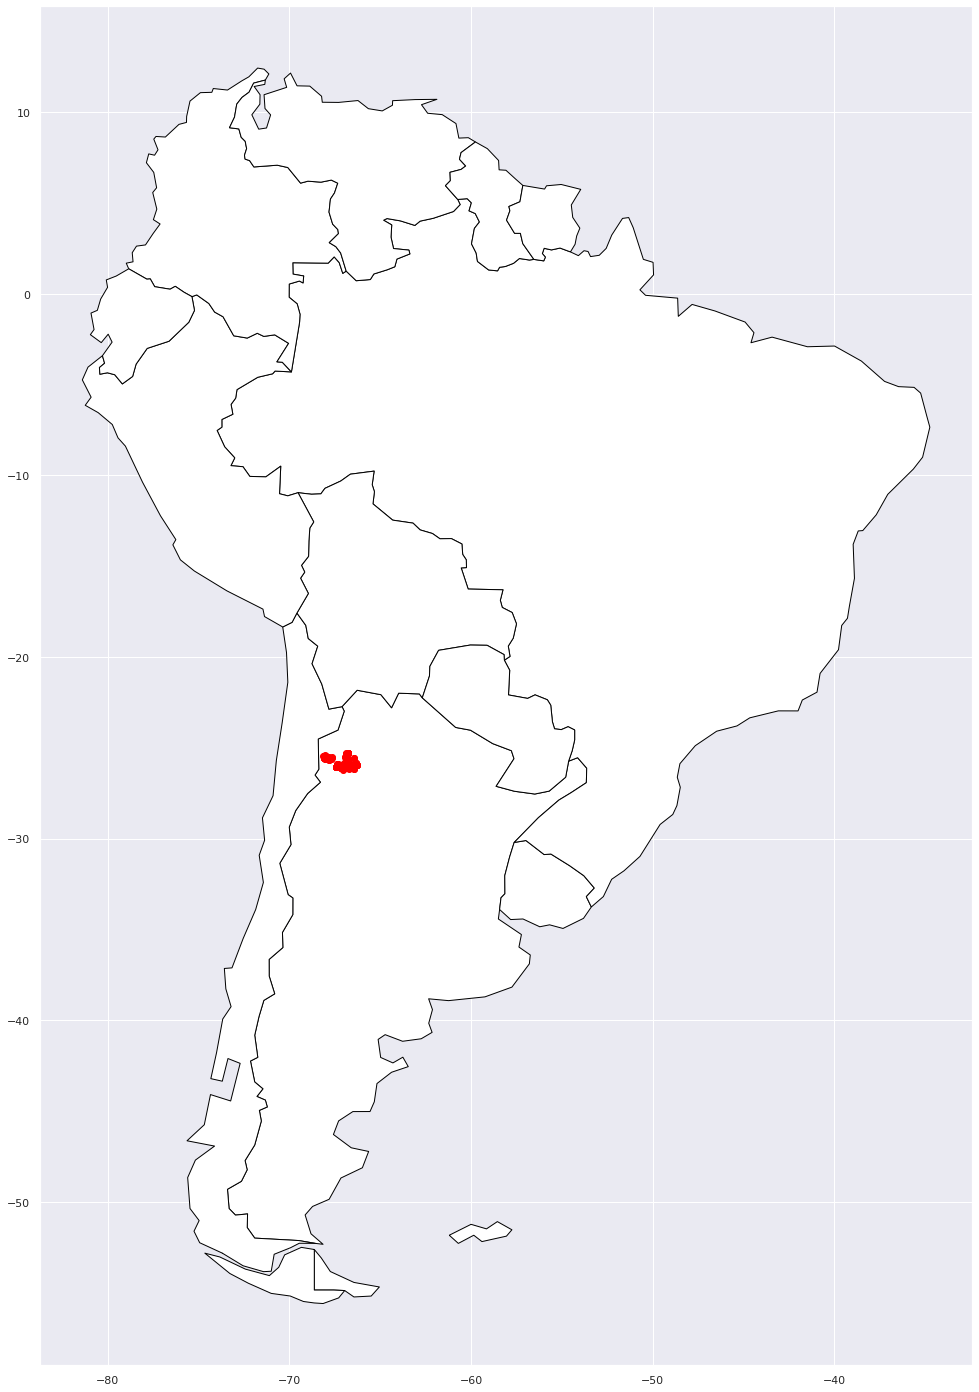

In [6]:

target = {#'MAMANI, M.; WÖRNER, G.; SEMPERE, T., 2010':1,
          'FOLKES, C. B.; DE SILVA, S. L.; WRIGHT, H. M. N.; CAS, R. A. F., 2011':2,
          'KAY, S. M.; COIRA, B. L.; WÖRNER, G.; KAY, R. W.; SINGER, B. S., 2011':3,
          'RICHARDS, J. P.; ULLRICH, T. D.; KERRICH, R., 2006':4,
        # 'LEBTI, P. P.; THOURET, J.-C.; WÖRNER, G.; FORNARI, M., 2006':5,
          'WRIGHT, H. M. N.; FOLKES, C. B.; CAS, R. A. F.; CASHMAN, K. V., 2011':6, 
          #'MATTHEWS, S. J.; SPARKS, R. S. J.; GARDEWEG, M. C., 1999':8,
          'GUZMAN, S. R.; PETRINOVIC, I. A.; BROD, J. A.; HONGN, F. D.; SEGGIARO, R. E.; MONTERO, C.; CARNIEL, R.; DANTAS, E. I.; SUDO, M., 2011':9,
          }

data_baby = df

data_baby['target']= data_baby['REFERENCE'].map(target)

# Missing values are given a '?'. First replace them with np.NaN to facilitate removing them with pandas:
data_baby['target'] = data_baby['target'].fillna(0)
# Make target column int
data_baby['target'] = data_baby['target'].astype(float).astype(int)

# Drop targets that are not in top 10 references
data_baby =data_baby[data_baby['target'] >=1]

# select multiple columns
data_5 = data_baby[all_variables] #.loc[:,['LATITUDE', 'LONGITUDE', 'target']]

#print(data_baby)

gdf = geopandas.GeoDataFrame(data_baby, geometry=geopandas.points_from_xy(data_baby['LONGITUDE'],data_baby['LATITUDE']))
#print(gdf.head)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black',figsize = (40,25))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')


plt.show()



In [7]:
# Target column: 1 within the cluster; 0 not in the cluster
data_5['target'] = 1
data_5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,LONGITUDE,LATITUDE,SIO2,TIO2,AL2O3,FEOT,MNO,MGO,CAO,NA2O,K2O,P2O5,BA,RB,SR,TH,ZR,target
184,-67.2095,-25.9751,70.344,0.638,14.502,2.987,0.057,1.310,2.376,3.270,4.315,0.200,327.859,266.508,225.974,32.6308,178.347,1
185,-67.2095,-25.9751,67.111,0.614,15.494,2.849,0.052,1.417,3.297,4.176,4.786,0.204,496.000,244.121,315.000,26.5070,177.728,1
186,-67.2100,-25.9800,68.089,0.531,16.421,2.904,0.040,1.111,3.304,3.805,3.605,0.190,436.000,204.800,338.900,17.9000,148.900,1
187,-67.2100,-25.9800,77.440,0.150,12.539,0.752,0.030,0.110,0.853,2.307,5.818,NaN,NaN,NaN,NaN,NaN,NaN,1
188,-67.2100,-25.9800,78.932,0.110,12.405,0.310,0.030,0.040,0.770,1.701,5.702,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,-66.5820,-26.1272,63.816,0.698,16.324,4.631,0.104,2.271,4.656,2.750,4.417,0.333,593.000,179.000,485.000,14.6000,195.000,1
3029,-66.8100,-25.8500,69.921,0.610,14.804,3.001,0.050,1.190,2.801,3.401,4.001,0.220,282.100,255.700,264.100,30.8000,169.000,1
3030,-66.8100,-25.8500,70.393,0.590,14.599,2.900,0.050,1.160,2.600,3.300,4.200,0.210,253.500,325.200,243.700,31.1000,179.800,1
3031,-66.8245,-25.8536,68.945,0.610,15.288,2.998,0.050,1.219,2.698,3.197,4.796,0.200,592.500,258.000,295.700,34.0000,213.300,1


In [8]:
# Add target column to full dataset 
data_all["target"] = data_5["target"]

# For all samples not from cluster: target = 0
data_all['target'] = data_all['target'].fillna(0)

data_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,SAMPLE ID,SOURCE,REFERENCE,LATITUDE,LONGITUDE,LOC PREC,MATERIAL,TYPE,COMPOSITION,ROCK NAME,SIO2,TIO2,AL2O3,FEOT,MNO,MGO,CAO,NA2O,K2O,P2O5,BA,RB,SR,TH,ZR,target
0,080385-4,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",-41.1000,-72.4930,0.01,igneous,volcanic,felsic,dacite,69.144,0.565,14.590,4.261,0.081,1.111,3.544,4.402,2.141,0.162,550.0,69.1,190.0,8.60,282.0,0.0
1,230483-3,GEOROC,"HICKEY-VARGAS, R.; HOLBIK, S.; TORMEY, D. R.; ...",-41.1000,-72.4930,0.01,igneous,volcanic,felsic,dacite,63.541,0.796,16.427,5.973,0.121,1.732,5.136,4.562,1.460,0.252,396.0,45.6,294.0,4.30,195.0,0.0
2,PU-02-34,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5088,-72.2060,0.01,igneous,volcanic,felsic,dacite,70.931,0.340,13.794,4.671,0.140,0.310,1.771,5.182,2.791,0.070,747.0,62.0,138.0,8.30,307.0,0.0
3,PU-02-25,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5275,-72.1812,0.01,igneous,volcanic,felsic,dacite,70.047,0.688,14.039,4.367,0.110,0.638,2.154,5.195,2.612,0.150,776.0,73.0,161.0,9.18,342.0,0.0
4,PU-02-20,GEOROC,"SINGER, B. S.; JICHA, B. R.; HARPER, M. A.; NA...",-40.5675,-72.1743,0.01,igneous,volcanic,felsic,dacite,69.367,0.531,14.150,5.167,0.150,0.471,2.213,5.167,2.664,0.120,692.0,66.0,197.0,8.82,308.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,RIG187,GEOROC,"DAVIDSON, J. P.; MCMILLAN, N. J.; MOORBATH, S....",-18.2458,-69.2194,0.01,igneous,volcanic,felsic,rhyolite,75.549,0.205,13.303,1.201,0.051,0.185,0.893,3.880,4.681,0.051,296.0,146.0,157.0,18.40,108.0,0.0
3056,AJO 017,GEOROC,"MAMANI, M.; WÖRNER, G.; SEMPERE, T., 2010",-18.2167,-69.2125,0.01,igneous,volcanic,felsic,rhyolite,74.796,0.274,13.367,1.418,0.071,0.478,1.078,3.680,4.808,0.030,513.0,40.4,512.6,4.00,73.0,0.0
3057,AJO017,GEOROC,"DAVIDSON, J. P.; MCMILLAN, N. J.; MOORBATH, S....",-18.2458,-69.2194,0.01,igneous,volcanic,felsic,rhyolite,75.237,0.258,13.388,1.419,0.072,0.381,1.051,3.545,4.607,0.041,638.0,146.0,147.0,16.30,121.0,0.0
3061,CHO 099,GEOROC,"MAMANI, M.; WÖRNER, G.; SEMPERE, T., 2010",-18.3014,-69.2431,0.01,igneous,volcanic,felsic,dacite,66.728,0.555,17.025,3.542,0.030,0.807,3.845,4.087,3.199,0.182,766.0,61.0,508.0,5.00,101.0,0.0


Plot Data: Red all the samples & Blue shows the selected samples we are training/testing 

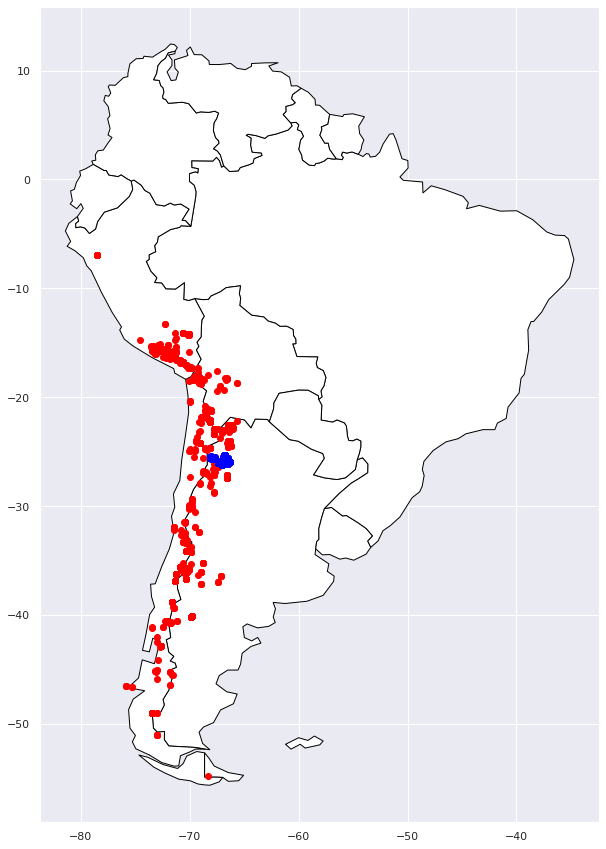

In [9]:
# Plot all samples
gdf = geopandas.GeoDataFrame(data_all, geometry=geopandas.points_from_xy(data_all['LONGITUDE'],data_all['LATITUDE']))


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

  # We restrict to South America.
ax = world[world.continent == 'South America'].plot(color="white", edgecolor='black',figsize = (25,15))

  # We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='red')


# Plot samples we are selecting to train/test
gdf = geopandas.GeoDataFrame(data_5, geometry=geopandas.points_from_xy(data_5['LONGITUDE'],data_5['LATITUDE']))
  # We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='blue')
plt.show()



In [10]:
# Classification: Can i tell if a rock comes from this region 

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn import *

X = data_all[cluster_variables].astype(int)
y = data_all['target'].astype(int)

In [12]:
# Scale and transform X data

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

X = preprocessing.StandardScaler().fit(X).transform(X)

In [13]:
# Use StratifiedShuffleSplit()
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.3,
                             random_state=42)
sss.get_n_splits(X, y)

4

In [14]:
scores = []
  
# using regression to get predicted data
rf = RandomForestClassifier(n_estimators=100, max_depth=2)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    scores.append(accuracy_score(y_test, pred))
  
# get accurracy of each prediction
print(scores)

[0.9140401146131805, 0.9255014326647565, 0.9083094555873925, 0.9054441260744985]


Here, we see that we get an accurracy score of ~90%

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [16]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [915 246]
Labels counts in y_train: [640 172]
Labels counts in y_test: [275  74]


In [17]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [18]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.6, random_state=42)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.6,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:

y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())
 # 50/ 349 = 14%

Misclassified examples: 50


Here, we see that after scaling and fitting our data, we missclassify our training data around 14%

In [20]:
from sklearn.metrics import accuracy_score
print('Accuracy y: %.3f' % accuracy_score(y_test, y_pred))
print('Accuracy X: %.3f' % ppn.score(X_test_std, y_test))
# Accuracy y: 0.857
# Accuracy X: 0.857

Accuracy y: 0.857
Accuracy X: 0.857


With this model, we see that our accuracy at predicting our samples is around 85%

In [21]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

In [22]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# 21 & 22 wrong predictions 

array([[254,  21],
       [ 22,  52]])

In [23]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

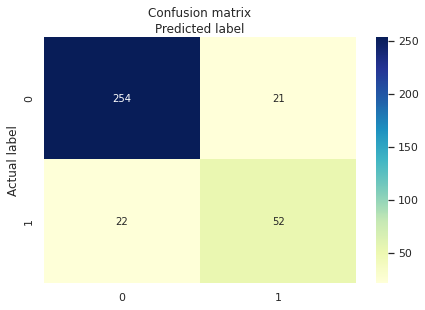

In [24]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

From the confusion matrix, we see that we get a true negative 254 times, true positive 52 times, False positive 21 times, and False negative 22 times. From the scale, we see that we can predict true negatives more than true positives. With the same accuracy at false negatives/ positives

In [25]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8767908309455588
Precision: 0.7123287671232876
Recall: 0.7027027027027027


Here, we see that we have an accuracy of 87%. This is slightly lower than our RandomForest Classifier. With a Precision of 71% and Recall of 70%

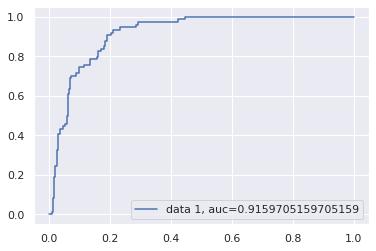

In [26]:
# Receiver Operating Characteristic(ROC) curve:
# Plotting of the true positive rate against the false positive rate

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# AUC score 1 represents perfect classifier, 
#     and 0.5 represents a worthless classifier.
# AUC score for the case is 0.91. ( Pretty good )

Here we see a Reciever operating curve which shows true positives rate against false positive rate. We see that we get a AUC score of 0.91 which is pretty good suggesting that we have a decent classifier. 

Coefficients: 
 [ 4.84081334e-03 -1.85792056e-02  1.45640403e-03  1.20731160e-02
  1.38777878e-17 -1.22375465e-02  6.37617606e-02 -2.39242421e-02
  5.03001213e-02  0.00000000e+00 -8.76129620e-02  5.40976079e-02
  5.33884685e-02  2.06550182e-01  2.06397971e-03]
Residual sum of squares: 0.11
Variance score: 0.36


ValueError: ignored

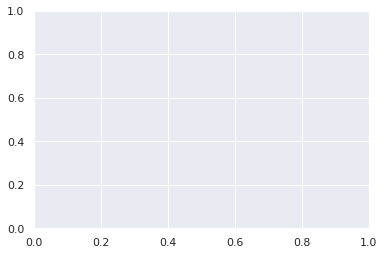

In [38]:
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, regr.predict(y_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Questions / Thoughts
- I have no idea how to make a plot of a logistic regression with gradient descent with multiple features. It seems that the textbook and the internet have used examples with a 2D array ( ex: iris petal width vs. length).  
- To make cool plots: How can I preserve the long lat of randomly selected training and test samples before i go about standardizing them so that I can later use the samples long/lat to plot whether or not my model worked by showing samples on a map? 

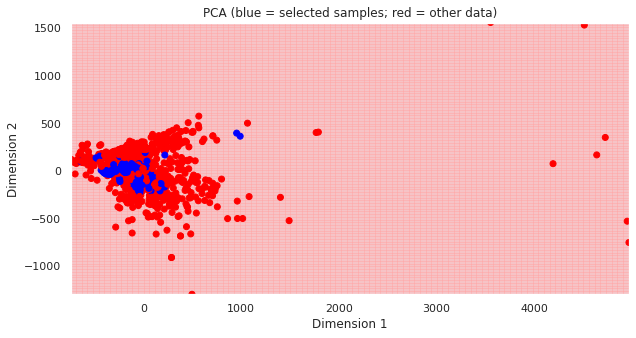

In [29]:
# SVM ALL samples
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

X = data_all[cluster_variables].astype(int)
y = data_all['target'].astype(int)


pca = PCA()
X_pca = pca.fit_transform(X)
X_selected = X_pca[:,:2]

# training classifier and evaluating on the whole plane
clf = SVC(kernel='linear')
clf.fit(X_selected,y)

x_min, x_max = X_selected[:, 0].min() - .1, X_selected[:, 0].max() + .1
y_min, y_max = X_selected[:, 1].min() - .1, X_selected[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA (blue = selected samples; red = other data)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y,cmap=cmap_bold)
plt.show()





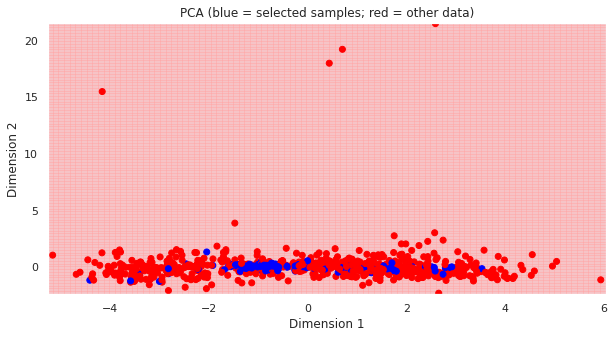

In [32]:
# SVM Training 

from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

#X = data_all[cluster_variables].astype(int)
#y = data_all['target'].astype(int)


pca = PCA()
X_pca = pca.fit_transform(X_train)
X_selected = X_pca[:,:2]

# training classifier and evaluating on the whole plane
clf = SVC(kernel='linear')
clf.fit(X_selected,y_train)

x_min, x_max = X_selected[:, 0].min() - .1, X_selected[:, 0].max() + .1
y_min, y_max = X_selected[:, 1].min() - .1, X_selected[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA (blue = selected samples; red = other data)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_train,cmap=cmap_bold)
plt.show()





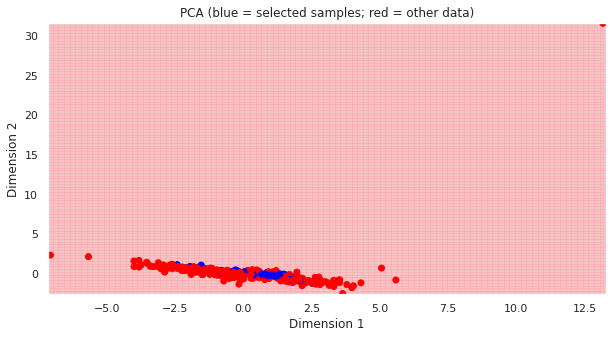

In [44]:
# SVM Test

from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

#X = data_all[cluster_variables].astype(int)
#y = data_all['target'].astype(int)


pca = PCA()
X_pca = pca.fit_transform(X_test)
X_selected = X_pca[:,:2]

# training classifier and evaluating on the whole plane
clf = SVC(kernel='linear')
clf.fit(X_selected,y_test)

x_min, x_max = X_selected[:, 0].min() - .1, X_selected[:, 0].max() + .1
y_min, y_max = X_selected[:, 1].min() - .1, X_selected[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)


# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA (blue = selected samples; red = other data)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_test,cmap=cmap_bold)
plt.show()





In [33]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


X = data_all[cluster_variables]
y = data_all['target']

pca = PCA()
X_pca = pca.fit_transform(X)
X_selected = X_pca[:,:2]

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_selected, y)

x_min, x_max = X_selected[:, 0].min() - .1, X_selected[:, 0].max() + .1
y_min, y_max = X_selected[:, 1].min() - .1, X_selected[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

ValueError: ignored

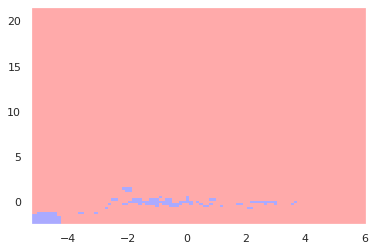

In [43]:
#KNeighborsClassifiers ALL N=1
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y, cmap=cmap_bold)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('tight')

In [42]:
#KNeighborsClassifiers ALL N=2

knn = neighbors.KNeighborsClassifier(n_neighbors=2)
knn.fit(X_selected, y)

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y, cmap=cmap_bold)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('tight')

plt.show()


ValueError: ignored

(-5.268647863192597,
 6.030592343232617,
 -2.4567036915136526,
 21.551660994818263)

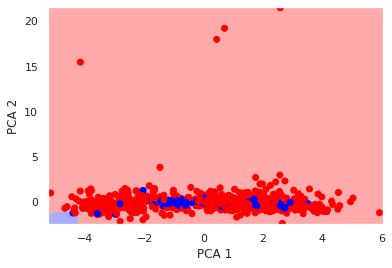

In [41]:
#KNeighborsClassifiers Train

pca = PCA()
X_pca = pca.fit_transform(X_train)
X_selected = X_pca[:,:2]

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_selected, y_train)

x_min, x_max = X_selected[:, 0].min() - .1, X_selected[:, 0].max() + .1
y_min, y_max = X_selected[:, 1].min() - .1, X_selected[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y_train, cmap=cmap_bold)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('tight')

(-7.166046151814808,
 13.27180508343904,
 -2.6601722866086135,
 31.591604976284895)

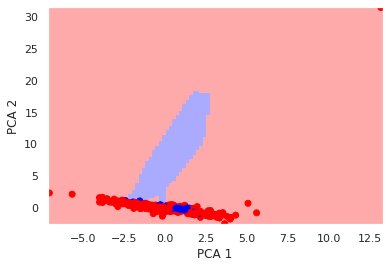

In [40]:
#KNeighborsClassifiers Test

pca = PCA()
X_pca = pca.fit_transform(X_test)
X_selected = X_pca[:,:2]

knn = neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_selected, y_test)

x_min, x_max = X_selected[:, 0].min() - .1, X_selected[:, 0].max() + .1
y_min, y_max = X_selected[:, 1].min() - .1, X_selected[:, 1].max() + .1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y_test, cmap=cmap_bold)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.axis('tight')